<a href="https://colab.research.google.com/github/simonians/tesis-economia-fce-unc/blob/main/trabajo_final_econom%C3%ADa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Final de la Lic. En Economía - En código 💻

El modelado del trabajo está dividido en 7 secciones: 


*   En la **sección 1** se hace la preparación de los datos, se cargan los tickers a usar a lo largo del trabajo, se calculan indicadores y demás variables predictoras. El DoD de esta sección es dejar un DF final para en la sección posterior dividir el mismo en el conjunto de entrenamiento y de testeo
*   En la **sección 2** se realiza el procesamiento del dataset. Se divida el mismo en el conjunto de entrenamiento y de testeo (por defecto se utilizan el 80% de las observaciones para entrenar la red LSTM). Se define la mejor forma de normalizar los datos y se genera la matríz de predictoras y el vector de variables predichas.
*   En la **sección 3** se construye la single layer LSTM. 
*   En la **sección 4** se entena la red compilada en un paso previo. Además se define una clase para computar el tiempo de ejecución en cada época (parámetro usado como referencia del costo computacional de la red previamente definida). 
*   En la **sección 5** se realizan las predicciones con la red entrenada previamente. Estas predicciones se realizan sobre el dataset de testeo generado en la etapa 2.
*   En la **sección 6** se visualizan los resultados de las predicciones realizadas en la sección previa. Para esto se generan 3 tipos de gráficos: Scatter-plot, Line-plot y un Error-Plot.
*   En la **sección 7** se calculan los indicadores de Performance de la red. Para computar el costo computacional se calcula la media y mediana de cada epoch y el tiempo total de entrenamiento de la red. Para medir el rendimiento predictivo de la red se calculan el MSE (Mean-Square-Error) y el r2 (coeficiente de determinación).
*   Finalmente  la última sección del trabajo, el **Bonus Track**, es usada para evaluar cada una de las arquitecturas de red LSTM definidas (con 25, 50, 75 y 100 neuronas en la capa oculta) con su configuración óptima de hiperparámetros previamente calculado. 


# Parte 1: Preparación de los datos

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import random

Primero definimos los tickers a usar a lo largo del proyecto y la fecha que nos interesará entrenar a la red.

In [3]:
DEFAULT_TICKERS = ['JPM'] 
START, END = "2010-01-01", "2020-01-01"  

Luego definimos las funciones que utilizaremos para cargar los datos usando la biblioteca yfinance de python.

In [5]:
# Use load_ticker to load the ticker information sent as parameter and the industry information price.
def load_ticker(ticker, industry='SPY', use_industry=False, start=START, end=END):
    """
    Use load_ticker to load the ticker information sent as parameter and the industry information price.
    """
    ticker_data = yf.download(ticker, start=start, end=end)
    if use_industry:
      ticker_data = ticker_data[['Close', 'Volume', 'High', 'Low']].rename(columns={'Close': 'Close_Price_%s' % (ticker), 'Volume': 'Volume', 'High': 'High_Price', 'Low': 'Low_Price'}) 
      industry_data = yf.download(industry, start=START, end=END)[['Close']].rename(columns={'Close': 'Close_Price_%s'% (industry)})
      ticker_data = pd.merge(ticker_data, industry_data, how='left', on='Date')
    else:
      ticker_data = ticker_data[['Close', 'Volume', 'High', 'Low']].rename(columns={'Close': 'Close_Price_%s' % (ticker), 'Volume': 'Volume', 'High': 'High_Price', 'Low': 'Low_Price'}) 
    return ticker_data
  
def calculate_sma(days, df, ticker):
    """
    To apply simple moving average (SMA) over a specific ticker and number of periods sent as parameters
    """
    sma_df = df['Close_Price_%s' % (ticker)].rolling(window=days).mean().to_frame()
    return sma_df.rename(columns={'Close_Price_%s' % (ticker):'%s_sma' % (ticker)})

def calculate_rsi(df, ticker):
    """
    To apply relative strength index (RSI) over a specific ticker sent as parameter
    """
    delta = df['Close_Price_%s' % (ticker)].diff()
    positive = delta.clip(lower=0)
    negative = -delta.clip(upper=0)
    ema_positive = positive.ewm(alpha=1/14, min_periods=14).mean()
    ema_negative = negative.ewm(alpha=1/14, min_periods=14).mean()
    rsi = 100 - 100 / (1 + ema_positive / ema_negative)
    rsi = rsi.to_frame()
    return rsi.rename(columns={'Close_Price_%s' % (ticker):'%s_rsi' % (ticker)})

def get_random_ticker(tickers):
    return random.choice(tickers)

def merge_dfs(dfs_list):
  merged_df = reduce(lambda left, right: pd.merge(left, right, on='Date'), dfs_list)
  return merged_df.dropna()

In [ ]:
ticker_name = get_random_ticker(DEFAULT_TICKERS)
ticker = load_ticker(ticker_name, use_industry=True)
rsi = calculate_rsi(ticker, ticker_name)
sma = calculate_sma(20, ticker, ticker_name)

ticker_df_final = merge_dfs([ticker, rsi, sma])

In [14]:
ticker_df_final

,Close_Price_JPM,Volume,High_Price,Low_Price,Close_Price_SPY,JPM_rsi,JPM_sma
Date,,,,,,,
2010-02-01,39.630001,37408200,39.930000,38.950001,109.059998,35.773063,42.098500
2010-02-02,40.549999,45968500,40.680000,39.700001,110.379997,43.244476,41.983500
2010-02-03,40.290001,37373300,41.099998,40.169998,109.830002,41.765795,41.814000
2010-02-04,38.349998,57211800,39.919998,38.349998,106.440002,32.763543,41.535500
2010-02-05,38.299999,75224100,38.880001,37.029999,106.660004,32.568703,41.211000
...,...,...,...,...,...,...,...
2019-12-24,137.580002,3324300,137.630005,137.059998,321.230011,68.430560,134.901498
2019-12-26,139.039993,6770900,139.100006,137.779999,322.940002,72.464635,135.269998
2019-12-27,139.139999,7868200,139.770004,138.669998,322.859985,72.721765,135.623998


# Parte 2: Procesamiento de los datos

In [25]:
import pandas as pd
import numpy as np
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

## Splitting

Primer punto es la separación del total de datos en un conjunto de entrenamiento y uno para testeo / pruebas. Para esto definimos una función que recibe como parámetro el dataframe a separar y un valor (entre 0-1) que representa el porcentaje del df que queremos utilizar para entrenamiento.

In [15]:
def train_test_split(df, percentage_for_training=0.8):
  '''
  This function returns two data-frames: One df to train the network and the other to evaluate the performance of that network 
  '''
  index_percentage = int(len(df) * percentage_for_training)
  train_df = df[:index_percentage]
  test_df = df[index_percentage:]
  return train_df, test_df

train_df, test_df = train_test_split(ticker_df_final)

## Feature scaling

Normalización del df de entrenamiento. Creamos una función que retornará, para cada fila del df pasado por parámetro, el valor del df normalizado, es decir:

- Para cada columna de la fila del df, restarle el mínimo y devidirlo por la 
diferencia entre el maximo y el mínimo del conjunto (de la columna bajo análisis). Para esto, creamos una función que la denominamos normalization(), que recibe por parámetro un dataframe a normalizar. Utiliza como método de normalización el MinMaxScaler de la librería sklearn.

In [18]:
def make_normalization(df_to_normalize, scaler):
  return scaler.fit_transform(df_to_normalize)
  
scaler = MinMaxScaler(feature_range = (0,1))
training_set_scaled = make_normalization(train_df, scaler)

## Creating feature-matriz and target-vector

- X_train => es un vector de tantos elementos como el conjunto de entrenamiento, donde cada elemento representa 60 jornadas previas operadas que se utilizarán como input para el calculo del output del precio de la jornada estimada. Entre los inputs se encuentra el precio de cierre, volumen operado, precio máximo de la jornada, precio mínimo de la jornada, precio de cierre del SPY, el valor del RSI y SMA.
- y_train => array donde cada elemento representa el valor del precio de la acción en la jornada estimada, es decir el precio de cierre del día siguiente para cada fila del conjunto de entrenamiento

In [20]:
def feature_matrix_target_vector_split(training_set):
    X_train = []
    y_train = []
    timesteps = 60
    total_times = len(training_set)
    for step in range(timesteps, total_times):
        X_train.append(training_set[step-timesteps:step, :]) # appendo los 60 valores de las variables independientes previas al precio que estoy estimando
        y_train.append(training_set[step, 0]) # appendo el precio de la estimación
    X_train, y_train = np.array(X_train), np.array(y_train)
    return X_train, y_train
  
X_train, y_train = feature_matrix_target_vector_split(training_set_scaled)

## Reshaping

El objetivo de esta sección es transformar los valores de entrada y salida (matríz de características y el vector de etiquetas) en un formato adecuado para poder ser procesdos por la red. Así en nuestro caso tendremos lo siguiente:

La matriz de características (jpm_X_train) debe tener tres dimensiones: número de observaciones, timestep y número de variables de entrada. En este caso, tenemos X_train con forma (número de observaciones, 60, 7) que representa la información de las 60 jornadas previas con 7 variables de entrada para cada observación.
La matriz de etiquetas (jpm_y_train) debe tener dos dimensiones: número de observaciones y número de variables de salida. En este caso, tenemos y_train con forma (número de observaciones, 1) que representa el valor del precio de cierre para cada observación.

In [23]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
reshapingMsg = "Reshaping feature matrix.\nThe first value is the batch size, the second the timesteps and the third the indicators.\n   X_train.shape[0] = {shape_cero} \n   X_train.shape[1] = {shape_one}\n   X_train.shape[2] = {shape_two}".format(shape_cero=X_train.shape[0], shape_one = X_train.shape[1], shape_two=X_train.shape[2])
print(f"{reshapingMsg}")

y_train = np.reshape(y_train, (y_train.shape[0], 1))
reshapingMsg = "\nReshaping target vector.\nThe first value is the batch size and the second the number of outputs.\n   y_train.shape[0] = {shape_cero} \n   y_train.shape[1] = {shape_one}".format(shape_cero=y_train.shape[0], shape_one = y_train.shape[1])
print(f"{reshapingMsg}")

Reshaping feature matrix.
The first value is the batch size, the second the timesteps and the third the indicators.
   X_train.shape[0] = 1937 
   X_train.shape[1] = 60
   X_train.shape[2] = 7

Reshaping target vector.
The first value is the batch size and the second the number of outputs.
   y_train.shape[0] = 1937 
   y_train.shape[1] = 1


# Parte 3: Construyendo la red LSTM

Para la construcción de la arquitectura de nuestra RNN importaremos: 


*   Sequential => Nos permitirá crear un objeto de red neuronal que simule una secuencia de capas (hidden layers)
*   Dense => Es la clase que permite confeccionar la capa de salida (output layer). Es una fully connected layer y nos permite ajustar la salida de la red al tamaño deseado.
*   LSTM => Para añadir las capas LSTM. 
*   Dropout => Regularización de droput, usado para evitar el overfitting. 

In [67]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam,RMSprop,SGD

### Initialising the RNN

El regressor es un objeto de una capa Secuencial. A diferencia de las ANN o CNN, en RNN a este objeto lo llamamos Regressor y no Clasificator porque lo que buscamos es predecir un valor continuo (en nuestro caso el precio de una acción) y no una clasificación de objetos.

In [28]:
regressor = Sequential()

### Making and compiling the RNN

En el paso siguiente definiremos la función init_network() que será la encargada de confeccionar la arquitectura de la single layer LSTM junto a la capa de salida y compilar la red. 
La capa LSTM tiene los siguientes argumentos:

*   El primer argumento es el número de unidades de memoria (más conocidas como neuronas) que tendrá la primera capa. Probaremos 4 arquitecturas de red diferentes hasta elegir la más performante: 

> - Single-layer LSTM con 25 neuronas
> - Single-layer LSTM con 50 neuronas
> - Single-layer LSTM con 75 neuronas
> - Single-layer LSTM con 100 neuronas

*   El segundo es un booleano (return_sequences) que básicamente indica si habrá una nueva capa LSTM próxima, por ende lo colocaremos en FALSE (dado que nuestro trabajo evaluaremos únicamente una single-layer LSTM)
*   El tercer parámetro es el input_shape que básciamente es la forma de entrada que contendrá el número de observaciones, steptimes y las características. 
Luego de agregado de la capa LSTM hay que agregar la regularización de abandono (dropout) que cuenta únicamente con un argumento que es la tasa de dropout y que indica el número de neuronas que se están dispuestas a eliminar para hacer esa regularización (se recominda usar una tasa del 20%) lo que implicará que el 20% de las neuronas se dejarán de lado para el forwardpropagation y el backpropagation. 

Para la confección de la **capa de salida** usamos la clase Dense de Keras. El argumento que hay que pasar es el número de unidades (units) que básicamente son la cantidad de neuronas. Dado que lo que estamos intentando predecir es un precio, es decir un valor continuo y único, el número de neuronas será igual a la unidad.

En la **compilación** necesitamos elegir el optimizador, el learning_rate y la función de pérdida utilizada para calcular el error. Utilizaremos ADAM como optimizador (es bastante potente y seguro) y para la función de pérdida usaremos mean-square-error (dado que estamos ante un problema de regresión). En nuestro caso el learning rate será uno de los hiperparámetros que variaremos de valor hasta elegir el que mejor performance genera. 



In [31]:
def init_network(regressor, lr, neurons):
  '''
  This function returns a compiled single-layer LSTM
  '''
  regressor.add(LSTM(units = neurons, return_sequences = False, input_shape = (X_train.shape[1], X_train.shape[2])))
  regressor.add(Dropout(0.2))
  regressor.add(Dense(units = 1))
  regressor.compile(optimizer = Adam(learning_rate=lr), loss = 'mean_squared_error')
  return regressor

regressor = init_network(regressor, 0.001, 25)

# Parte 4: Entrenando la red LSTM

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import Callback
import time

Para entrenar la red neuronal necesitamos pasar 4 atributos:

- El primer atributo es el conjunto de entrenamiento (en nuestor caso la lista de precios de apertura normalizada).
- El segundo atributo son los outputs para el conjunto de entrenamiento, es decir la lista de precios para cada momento del tiempo T.
- El tercer valor es el número de épocas, que representa el número de veces que se presenta todo el conjunto de datos de entrenamiento a la red neuronal durante el entrenamiento. Si el número de épocas es demasiado bajo, la red neuronal puede no haber tenido suficiente tiempo para aprender patrones en los datos. Por otro lado, si el número de épocas es demasiado alto, la red neuronal puede ajustarse demasiado a los datos de entrenamiento y no generalizar bien a los datos nuevos
- Por último para entrenar la red necesitamos definir el batch_size o cantidad de lotes, que se refiere a la cantidad de ejemplos de entrenamiento que se propagan a través de la red neuronal antes de actualizar los pesos sinápticos. 
Setearemos inicialmente los valores del número de épocas y del tamaño de lotes.

---

Además para medir el costo computacional de la red LSTM mediremos lo que tarda cada época en correr. Oara esto crearemos la  clase **EpochTimer** que es un callback personalizado que registra el tiempo de inicio de cada época en el método **on_epoch_begin** y calcula la duración de la época en el método **on_epoch_end**. Luego, se crea una instancia de EpochTimer llamada epoch_timer y se pasa como un elemento de la lista de callbacks en el método fit() de entrenamiento. Durante el entrenamiento, se imprimirá el tiempo de ejecución de cada época en segundos. Además dicha clase tiene un array de tiempos de ejecución por época, al que denominamos epoch_times, que nos servirá para luego graficar los tiempos y poder calcular la media y mediana de los mismos.



In [ ]:
class EpochTimer(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        print("\nTiempo de ejecución de la época", epoch+1, ": ", round(epoch_time, 4), " segundos")

In [91]:
num_epochs = 50
batch_size = 64
epoch_timer = EpochTimer()
regressor.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, callbacks=[epoch_timer])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 7.4249e-04
Tiempo de ejecución de la época 1 :  0.7592  segundos
31/31 [==============================] - 1s 24ms/step - loss: 7.4249e-04
Epoch 2/50
30/31 [============================>.] - ETA: 0s - loss: 7.1207e-04
Tiempo de ejecución de la época 2 :  0.7574  segundos
31/31 [==============================] - 1s 24ms/step - loss: 7.0787e-04
Epoch 3/50
29/31 [===========================>..] - ETA: 0s - loss: 7.3734e-04
Tiempo de ejecución de la época 3 :  0.7408  segundos
31/31 [==============================] - 1s 24ms/step - loss: 7.3949e-04
Epoch 4/50
29/31 [===========================>..] - ETA: 0s - loss: 6.9336e-04
Tiempo de ejecución de la época 4 :  0.775  segundos
31/31 [==============================] - 1s 25ms/step - loss: 6.9143e-04
Epoch 5/50
30/31 [============================>.] - ETA: 0s - loss: 7.6046e-04
Tiempo de ejecución de la época 5 :  0.759  segundos
31/31 [==============================] - 1s 2

# Parte 5: Realizando predicciones

Primero definimos las funciones que serán necesarias para realizar predicciones de forma correcta

In [84]:
def generate_inputs_list(df, timesteps, values_to_predict=1):
  '''
  This function gets a df (best if this DF is already normalized) and generates an array with a length of the values to predict + total timesteps.
  Each row of that array will have a length like the total features.
  '''
  inputs = df[len(df) - values_to_predict - timesteps:]
  return inputs

def generate_list_to_predict(inputs, timesteps=60):
  X_test = []
  total_inputs = len(inputs)
  for i in range(timesteps, total_inputs): 
      X_test.append(inputs[i-timesteps:i, :])
  X_test = np.array(X_test) # Debemos obtener un nparray
  return np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

def make_predictions(list_to_predict, reference_df, predictor, ticker_name, scaler):
  '''
  This function returns two list: The first one contains the predicted prices, and the second one the normalizated predicted prices
  '''
  predicted_stock_prices_normalizated = predictor.predict(list_to_predict)
  predicted_stock_prices = make_desnormalization(predicted_stock_prices_normalizated, reference_df, scaler)
  return np.array(predicted_stock_prices).flatten(), np.array(predicted_stock_prices_normalizated).flatten()

def make_desnormalization(df_to_desnormalize, parameter_df_desnormalize , scaler):
  df_to_desnormalize = np.concatenate((df_to_desnormalize, np.zeros((df_to_desnormalize.shape[0], parameter_df_desnormalize.shape[1]-1))), axis=1)
  df_to_desnormalize = scaler.inverse_transform(df_to_desnormalize)
  return df_to_desnormalize[:,0]

def get_real_prices(test_df, ticker_name, scaler):
  normalizated_df = scaler.transform(test_df)
  df = test_df.loc[:, ['Close_Price_%s' % ticker_name]]
  return np.array(df).flatten(), normalizated_df[:,0]

Para realizar ahora las predicciones necesitamos crear una lista / array de listas, donde cada una de esa lista contendrá los 60 previos precios del activo y demás variables necesarias para estimar el precio en el momento T+1. Para obtener esa lista necesitamos primero definir el objeto **inputs**, que es un array de listas que contiene un renglón del df_final normalizado. Una vez el objeto inputs, podemos generar el objeto **X_test** que es el array que utilizaremos para realizar las predicciones.

In [85]:
input_scaler = MinMaxScaler(feature_range = (0, 1))
df_normalizated = make_normalization(ticker_df_final, input_scaler)
inputs = generate_inputs_list(df_normalizated, 60, len(test_df))
X_test = generate_list_to_predict(inputs)

Usando la función *make_predictions()* obtenemos dos listas: Una lista de precios predichos normalizados y otra lista de precios predichos desnormalizados con el scaler pasado por parámetro. 
Luego con la función *get_real_prices()* obtenemos dos listas también, pero esta vez de los precios reales del activo.

In [86]:
predicted_stock_prices, normalizated_predicted_stock_prices = make_predictions(X_test, ticker_df_final, regressor, ticker_name, input_scaler)
real_stock_prices, real_stock_prices_normalizated = get_real_prices(test_df, ticker_name, input_scaler)

16/16 [==============================] - 0s 8ms/step


Definimos una función para generar los DF de datos predichos vs reales:

In [87]:
def get_df_predicted_vs_real(list_of_real_prices, list_of_predicted_prices, normalizated=False):
  if normalizated:
    return pd.DataFrame({'Real price normalizated': list_of_real_prices, 'Predicted Price normalizated': list_of_predicted_prices})
  else:
    return pd.DataFrame({'Real price': list_of_real_prices, 'Predicted Price': list_of_predicted_prices})

In [88]:
predicted_vs_real = get_df_predicted_vs_real(real_stock_prices, predicted_stock_prices)
predicted_vs_real.index = test_df.index
predicted_vs_real

,Real price,Predicted Price
Date,,
2018-01-05,108.339996,108.310984
2018-01-08,108.500000,108.344759
2018-01-09,109.050003,108.407067
2018-01-10,110.250000,108.778775
2018-01-11,110.839996,109.557175
...,...,...
2019-12-24,137.580002,136.724345
2019-12-26,139.039993,136.889593
2019-12-27,139.139999,137.549815


# Part 6 - Visualizando los resultados

In [95]:
y_real = predicted_vs_real['Real price']
y_pred = predicted_vs_real['Predicted Price']

### Gráfico de dispersión (scatter plot):

*   Cada punto en el gráfico representa una observación, donde el eje x muestra los valores reales y el eje y muestra los valores predichos..
*   Si los puntos están cerca de la línea diagonal que atraviesa el gráfico (línea de 45 grados), indica que las predicciones se alinean bien con los valores reales.
*   Si los puntos se dispersan alrededor de la línea diagonal, indica cierta variabilidad en las predicciones. La dispersión puede ser esperada en algunos casos, especialmente cuando hay ruido o incertidumbre en los datos. 
*   Si los puntos se desvían significativamente de la línea diagonal o forman un patrón distinto, puede indicar un sesgo o error sistemático en las predicciones.


> *Al interpretar el scatter-plot, es importante observar la distribución de los puntos y la relación general entre los valores reales y los valores predichos. Un gráfico donde los puntos se agrupan cerca de la línea diagonal y no muestran un patrón claro sugiere una buena calidad de predicción.*



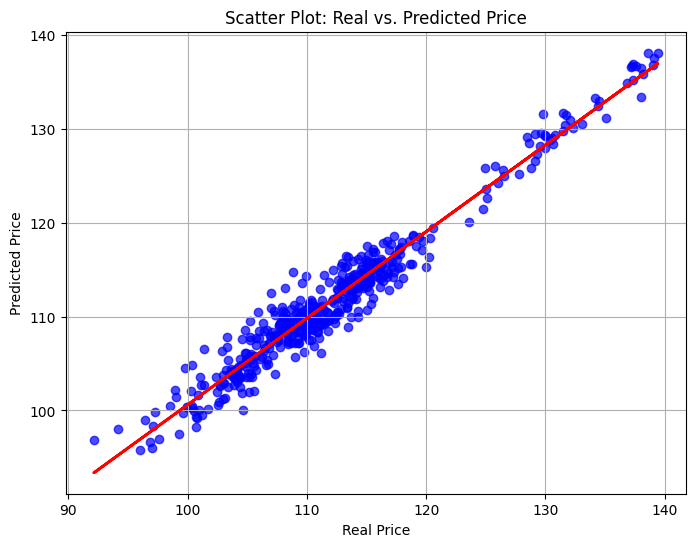

In [96]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_real, y_pred, color='b', alpha=0.7)

# Personalizar el gráfico
ax.set_xlabel('Real Price')
ax.set_ylabel('Predicted Price')
ax.set_title('Scatter Plot: Real vs. Predicted Price')
ax.grid(True)

# Añadir una línea de tendencia
fit = np.polyfit(y_real, y_pred, deg=1)
ax.plot(y_real, fit[0] * y_real + fit[1], color='r', linewidth=2)

plt.show()

### Gráfico de Líneas (Line Plot):

*   El eje x representa el tiempo, mientras que el eje y muestra los valores de los precios.
*   La línea negra representa los valores reales de los precios a lo largo del tiempo.
*   La línea roja representa los valores predichos de los precios a lo largo del tiempo. 
*   Si los puntos de la línea roja siguen de cerca los puntos de la línea negra, indica que las predicciones están en línea con los valores reales.
*   Si hay una discrepancia significativa entre las dos líneas, puede indicar que las predicciones no son precisas o que hay una diferencia entre los datos reales y los datos predichos.





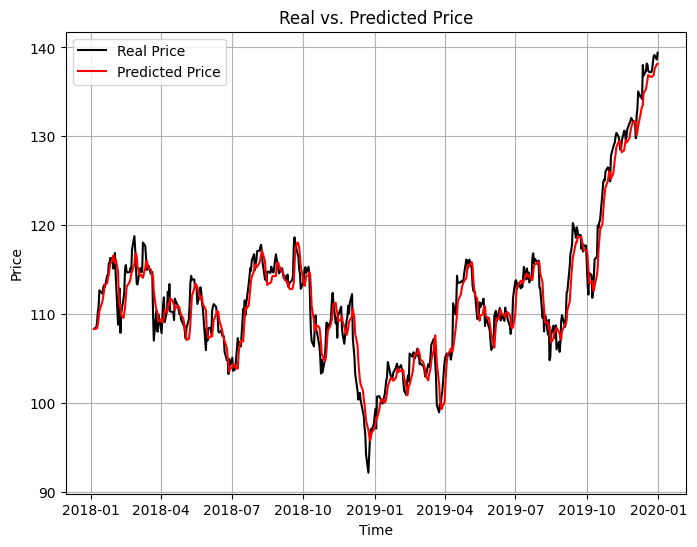

In [97]:
# Crear gráfico de líneas
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(y_real, color='black', label='Real Price')
ax.plot(y_pred, color='red', label='Predicted Price')

# Personalizar el gráfico
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Real vs. Predicted Price')
ax.grid(True)
ax.legend()

plt.show()


### Gráfico de Errores (Error Plot):
- El eje x representa el tiempo, mientras que el eje y muestra los errores de predicción.
- Los errores son la diferencia entre los valores reales y los valores predichos

> *Si los errores están cerca de cero o tienen una distribución aleatoria alrededor de cero, indica que las predicciones son precisas y están en línea con los valores reales.*



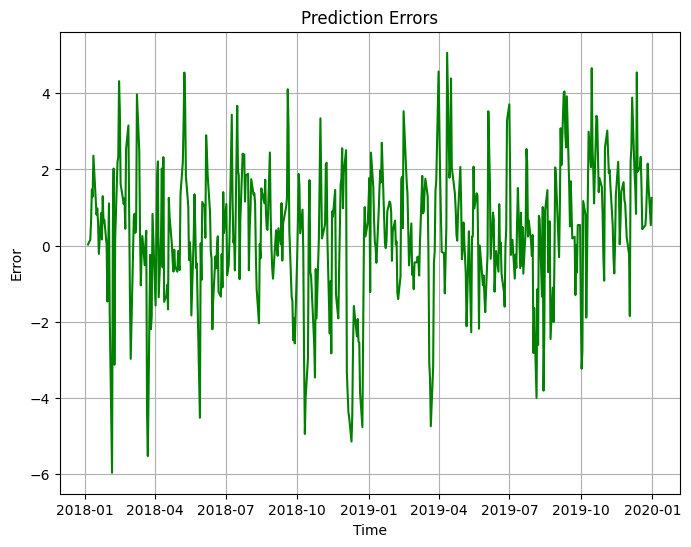

In [98]:
# Calcular los errores
errors = y_real - y_pred

# Crear gráfico de errores
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(errors, color='g')

# Personalizar el gráfico
ax.set_xlabel('Time')
ax.set_ylabel('Error')
ax.set_title('Prediction Errors')
ax.grid(True)

plt.show()

# Part 7 - Evaluando la performance de la red

## 7.1) Midiendo el costo computacional

Para medir el costo computacional calculamos:

*   La media y la mediana del tiempo de ejecución de cada época
*   Tiempo total de entrenamiento de la red



In [92]:
epoch_times = epoch_timer.epoch_times
mean_time = np.mean(epoch_times)
median_time = np.median(epoch_times)
total_time = mean_time*num_epochs
print('Tiempo de ejecución medio: {:.2f} segundos'.format(mean_time))
print('Tiempo de ejecución mediano: {:.2f} segundos'.format(median_time))
print('Tiempo de ejecución total: {:.2f} segundos'.format(total_time))

Tiempo de ejecución medio: 0.82 segundos
Tiempo de ejecución mediano: 0.75 segundos
Tiempo de ejecución total: 40.87 segundos


## 7.2) Midiendo el rendimiento de la red

Para medir la performance de la red, calcularemos dos indicadores:


*   Coeficiente de determinación => El coeficiente de determinación o R^2 es un indicador que varía entre 0 y 1, donde cuanto más tienda a 1 el valor, mejor será la cappacidad de predicción del modelo.
*   Mean-squeare-error (MSE) => El error cuadrático medio o MSE, mide el promedio de los errores al cuadrador entre las predicciones y los valores reales. Mientras más bajo el valor, mayor es la precisión del model



In [99]:
r2 = r2_score(y_real, y_pred)
print("Coeficiente de determinación (R^2):", r2)

Coeficiente de determinación (R^2): 0.9519831976529979


In [100]:
mse = mean_squared_error(y_real, y_pred)
print("Error cuadrático medio (MSE):", mse)

Error cuadrático medio (MSE): 3.2881669917177687


# Bonus Track: Evaluar cada arquitectura de red con los valores óptimos de los hiperparámetros

Defino la función start() que iterará 10 veces y en cada una de las iteracioes computa los valores de performance obtenidos (MSE,Coeficiente de determinación y el tiempo total de ejecución). 

In [ ]:
def start(lr, neurons, epochs, batch):
  mse_values = []
  r_values = []
  performance_times = []
  times = 10
  regressor = Sequential()
  regressor = init_network(regressor, lr, neurons)
  for i in range(0,times): 
    print("\nEmpezando la corrida numero: ", i, ", para la red de ", neurons, " neuronas")
    # training 
    epoch_timer = EpochTimer()
    history = regressor.fit(X_train, y_train, epochs=epochs, batch_size=batch, callbacks=[epoch_timer])

    # predictions
    predicted_stock_prices, predicted_stock_prices_normalizated = make_predictions(X_test, ticker_df_final, regressor, ticker_name, input_scaler)
    real_stock_prices, real_stock_prices_normalizated = get_real_prices(test_df, ticker_name, input_scaler)
    predicted_vs_real = get_df_predicted_vs_real(real_stock_prices, predicted_stock_prices)

    # compute performance ratios
    # computing performance 
    epoch_times = epoch_timer.epoch_times
    mean_time = np.mean(epoch_times)
    total_time = mean_time*num_epochs 
    performance_times.append(round(total_time, 3))

    # network performance
    y_real = predicted_vs_real['Real price']
    y_pred = predicted_vs_real['Predicted Price']
    mse = mean_squared_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    mse_values.append(round(mse, 3))
    r_values.append(round(r2, 3))

  return mse_values, performance_times, r_values

La clase Config tiene cada una de las configuraciones de los hiperparámetros óptimas para cada una de las arquitecturas de red LSTM (de 25, 50, 75 y 100 hidden-units). Además para cada una de estas arquitecturas óptimas, agregamos 3 atributos de performance: MSE_values, r2_values y performance_time, donde en cada uno de estos, en cada iteración de la red, computaremos los resultados de dicha iteración-

In [ ]:
from typing import NamedTuple
from typing import List

class Config(NamedTuple):
    hidden_units: int
    lr: float
    batch_size: int
    num_epochs: int
    MSE_values: List[float]
    r2_values: List[float]
    performance_time: List[float]

num_epochs = 50
rnn = Config(hidden_units=100, lr=0.001, batch_size=16, num_epochs=num_epochs, MSE_values=[], r2_values = [], performance_time=[])

mse_values, times, r2_val = start(rnn.lr, rnn.hidden_units, rnn.num_epochs, rnn.batch_size)
rnn = rnn._replace(MSE_values=mse_values, r2_values=r2_val, performance_time=times)

RateSummary es la clase que usaremos para guardar los resultados de cada uno de los indicadores de performance de la red y de costo computacional para cada una de las configuraciones óptimas de los hiperparámetros de cada arquitectura de la Single-Layer LSTM.

In [ ]:
class RateSummary(NamedTuple):
    min_value: float
    max_value: float
    average: float
    median: float
    std: float 

mse = rnn.MSE_values
mse_summary = RateSummary(min_value=round(np.min(mse),3), max_value=round(np.max(mse),3), average=round(np.mean(mse),3), median=round(np.median(mse),3), std=round(np.std(mse),3))

r2 = rnn.r2_values
r2_summary = RateSummary(min_value=round(np.min(r2),3), max_value=round(np.max(r2),3), average=round(np.mean(r2),3), median=round(np.median(r2),3), std=round(np.std(r2),3))

times = rnn.performance_time
ptime_summary = RateSummary(min_value=round(np.min(times),3), max_value=round(np.max(times),3), average=round(np.mean(times),3), median=round(np.median(times),3), std=round(np.std(times),3))

In [ ]:
print("Summaries: ")
print("- Performance Time summary: ", ptime_summary)
print("- Mean Square Error summary: ", mse_summary)
print("- R2: ", r2_summary)

Summaries: 
- Performance Time summary:  RateSummary(min_value=251.183, max_value=290.28, average=268.231, median=265.531, std=12.454)
- Mean Square Error summary:  RateSummary(min_value=2.204, max_value=7.942, average=3.179, median=2.574, std=1.643)
- R2:  RateSummary(min_value=0.884, max_value=0.968, average=0.953, median=0.962, std=0.024)
